# Object detection using RCNN

## Import necessary libraries

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Define paths for images and annotations

In [2]:
image_path = "image_data"
airplane_annotations = "annotations"

### Loop over annotation directory to read an image and display (image and its bounding boxes)

Planes3.jpg


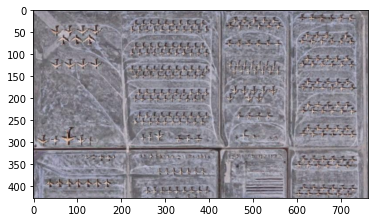

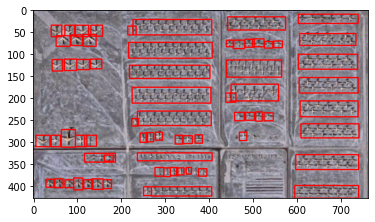

In [3]:
for i, e in enumerate(os.listdir(airplane_annotations)):
    if i < 10:
        filename = e.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(image_path,filename))
        df = pd.read_csv(os.path.join(airplane_annotations,e))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])    # iterate over each row and get
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break
#print(df)
#y2

### The first step in RCNN is Selective search. Lets initialize Selective search using createSelectiveSearchSegmentation() class of opencv library. 

- If you are getting error as module 'cv2' has no attribute 'ximgproc', follow the below procedure
- !pip3 uninstall opencv-contrib-python opencv-python
- !pip3 install opencv-contrib-python
- https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc

In [4]:
cv2.setUseOptimized(True);
ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

### Set one image as the base for selective search using setBaseImage(image)
### Selective search segmentation function uses hierarchical clustering to group pixels and then combine them into one based on color, texture or composition. The following is an implementation of the search code on the base image.

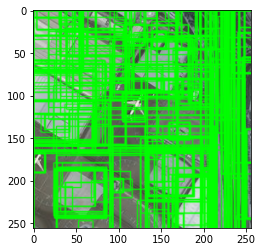

In [5]:
input_image = cv2.imread(os.path.join(image_path,"42850.jpg"))
ss_object.setBaseImage(input_image)
ss_object.switchToSelectiveSearchFast()  #this method of createSelectiveSearchSegmentation()
rects = ss_object.process()    # The output of the process is a set of a potential ROI’s, depending on the size of the base image
new_input_image = input_image.copy() # create copy of the base image
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(new_input_image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(new_input_image)

In [6]:
train_data=[]
train_labels_data=[]

## Function to calculate Intersection over union (IOU)

In [7]:
def calculate_iou(bb_1, bb_2):
    '''
  Now we are initialising the function to calculate IOU (Intersection Over Union) 
  of the ground truth box from the box computed by selective search.
  To divide the generated ROI’s, for example, we can use a metric called IoU. 
  It’s defined as the intersection area divided by area of the union of a predicted 
  bounding box and ground-truth box.
  '''
  
    assert bb_1['x1'] < bb_1['x2']    # The assert keyword lets you test if a condition in your code returns True, 
    assert bb_1['y1'] < bb_1['y2']    # if not, the program will raise an AssertionError.
    assert bb_2['x1'] < bb_2['x2']
    assert bb_2['y1'] < bb_2['y2']

    x_left = max(bb_1['x1'], bb_2['x1'])
    y_top = max(bb_1['y1'], bb_2['y1'])
    x_right = min(bb_1['x2'], bb_2['x2'])
    y_bottom = min(bb_1['y2'], bb_2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)

    bb_1_area = (bb_1['x2'] - bb_1['x1']) * (bb_1['y2'] - bb_1['y1'])
    bb_2_area = (bb_2['x2'] - bb_2['x1']) * (bb_2['y2'] - bb_2['y1'])

    iou_value = intersection / float(bb_1_area + bb_2_area - intersection)
    assert iou_value >= 0.0
    assert iou_value <= 1.0
    return iou_value

### Similarly :
- Loop over the image folder and set each image one by one as the base for selective search using setBaseImage(image) and get the proposed regions
- Initialising fast selective search and getting proposed regions using class switchToSelectiveSearchFast() and process().
- Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.
- Now as one image can have many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

In [8]:
MAX_REGION_PROPOSALS = 2000

In [9]:
for i, e in enumerate(os.listdir(airplane_annotations)):
    try:
        if e.startswith("airplane"):
            filename = e.split(".")[0]+".jpg"
            print(i,filename)
            image = cv2.imread(os.path.join(image_path,filename))
            df = pd.read_csv(os.path.join(airplane_annotations,e))
            coordinates=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                coordinates.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss_object.setBaseImage(image)
            ss_object.switchToSelectiveSearchFast()
            ss_results = ss_object.process()
            image_new = image.copy()
            min_positive_samples = 0
            min_negative_samples = 0
            flag = 0
            foreground_flag = 0
            background_flag = 0
            for region,ss_coordinate in enumerate(ss_results):
                if region < MAX_REGION_PROPOSALS and flag == 0:  # Iterating over all the first 2000 results only which are passed by selective search
                    for value in coordinates:
                        x,y,w,h = ss_coordinate           
                        iou = calculate_iou(value,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if min_positive_samples < 30:
                            if iou > 0.70:
                                mobile_obj_img = image_new[y:y+h,x:x+w]
                                resized_image = cv2.resize(mobile_obj_img, (224,224), interpolation = cv2.INTER_AREA)
                                train_data.append(resized_image)
                                train_labels_data.append(1)
                                min_positive_samples += 1
                        else :
                            foreground_flag = 1
                        if min_negative_samples < 30:
                            if iou < 0.3:
                                mobile_obj_img = image_new[y:y+h,x:x+w]
                                resized_image = cv2.resize(mobile_obj_img, (224,224), interpolation = cv2.INTER_AREA)
                                train_data.append(resized_image)
                                train_labels_data.append(0)
                                min_negative_samples += 1
                        else :
                            background_flag = 1
                    if foreground_flag == 1 and background_flag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error found in " + filename)
        continue

1 airplane_489.jpg
2 airplane_304.jpg
3 airplane_462.jpg
4 airplane_476.jpg
5 airplane_310.jpg
6 airplane_338.jpg
inside
7 airplane_660.jpg
8 airplane_106.jpg
9 airplane_112.jpg
inside
10 airplane_674.jpg
11 airplane_648.jpg
12 airplane_099.jpg
13 airplane_072.jpg
14 airplane_066.jpg
15 airplane_700.jpg
17 airplane_270.jpg
18 airplane_516.jpg
19 airplane_502.jpg
20 airplane_264.jpg
inside
21 airplane_258.jpg
22 airplane_259.jpg
23 airplane_503.jpg
24 airplane_265.jpg
25 airplane_271.jpg
26 airplane_517.jpg
28 airplane_067.jpg
29 airplane_073.jpg
30 airplane_098.jpg
31 airplane_649.jpg
32 airplane_113.jpg
33 airplane_675.jpg
34 airplane_661.jpg
35 airplane_107.jpg
36 airplane_339.jpg
37 airplane_477.jpg
38 airplane_311.jpg
39 airplane_305.jpg
inside
40 airplane_463.jpg
41 airplane_488.jpg
43 airplane_313.jpg
44 airplane_475.jpg
45 airplane_461.jpg
46 airplane_307.jpg
47 airplane_449.jpg
48 airplane_688.jpg
49 airplane_677.jpg
50 airplane_111.jpg
51 airplane_105.jpg
52 airplane_663.jpg
5

### train_data=[] will contain all the images and train_labels_data=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [10]:
# define independent and target features
X = np.array(train_data)
y = np.array(train_labels_data)

In [11]:
X.shape

(30229, 224, 224, 3)

In [12]:
y.shape

(30229,)

### Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model.

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.losses import CategoricalCrossentropy

In [14]:
vgg_model = VGG16(weights='imagenet', include_top=True)
vgg_model.summary()

2022-07-11 21:19:01.606326: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


553467904/553467096 [==============================] - 77s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

### In this part in the loop we are freezing the first 15 layers of the model. After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical. Finally the summary of the model is printed using summary() method of keras.

In [15]:
for layers in (vgg_model.layers)[:15]:
    print(layers)
    layers.trainable = False

In [16]:
x = vgg_model.layers[-2].output

In [17]:
x = Dense(2, activation="softmax")(x)

In [18]:
model = Model(inputs = vgg_model.input, outputs = x)

In [19]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [20]:
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [23]:
class My_Label_Binarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [24]:
lb_object = My_Label_Binarizer()
Y =  lb_object.fit_transform(y)

In [25]:
X_train, X_test , y_train, y_test = train_test_split(X , Y, test_size = 0.10)

In [26]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


### Now we will use Keras ImageDataGenerator to pass the dataset to the model. We will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.

In [27]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_data = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_data = tsdata.flow(x=X_test, y=y_test)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
checkpoints = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

### Now we start the training of the model using fit() method.

In [30]:
history = model.fit(train_data, steps_per_epoch= 10, epochs= 3, validation_data= test_data, validation_steps=2, callbacks=[checkpoints,early])

2022-07-11 21:22:00.948130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/3
10/10 [==============================] - 77s 7s/step - loss: 2.0394 - accuracy: 0.6588 - val_loss: 0.5262 - val_accuracy: 0.7344

Epoch 00001: val_accuracy improved from -inf to 0.73438, saving model to ieeercnn_vgg16_1.h5
Epoch 2/3
10/10 [==============================] - 63s 6s/step - loss: 0.4241 - accuracy: 0.8079 - val_loss: 0.2443 - val_accuracy: 0.9062

Epoch 00002: val_accuracy improved from 0.73438 to 0.90625, saving model to ieeercnn_vgg16_1.h5
Epoch 3/3
10/10 [==============================] - 61s 6s/step - loss: 0.3258 - accuracy: 0.8711 - val_loss: 0.1417 - val_accuracy: 0.9688

Epoch 00003: val_accuracy improved from 0.90625 to 0.96875, saving model to ieeercnn_vgg16_1.h5


### Save the model for direct future use

In [31]:
from tensorflow.keras.models import load_model
model.save("rcnn_model")
model.save_weights("rcnn_weights.h5")

loaded_model = load_model('rcnn_model')
loaded_model.load_weights("rcnn_weights.h5")

2022-07-11 21:25:33.550941: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rcnn_model/assets


### Plot training and validation loss for different epochs using keras loss and val_loss parameters and save the plot on disk. We can also plot training and validation accuracy.

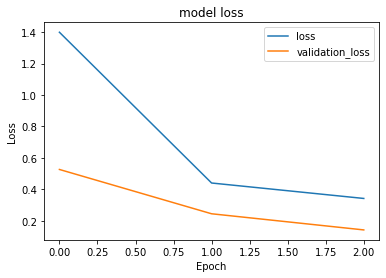

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","validation_loss"])
plt.show()
plt.savefig('chart_loss.png')


### Lets apply the trained model on to a random test image

Its a plane


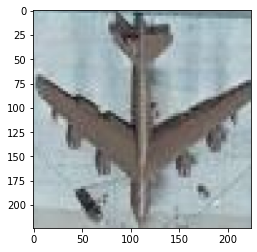

In [34]:
img = X_test[1700]
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
if result[0][0] > result[0][1]:
    print("Its a plane")
else:
    print("It is not plane")

In [ ]:
# lets predict for multiple test images

### Now once we have created the model. We need to do prediction on that model. For that we need to follow the steps mentioned below :
- Pass the image from selective search.
- Pass all the result of the selective search to the model as input using model_final.predict(img).
- If the output of the model says the region to be a foreground image (i.e. airplane image) and if the confidence is above the defined threshold then create bounding box on the original image on the coordinate of the proposed region.

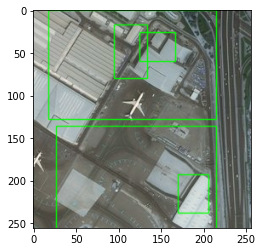

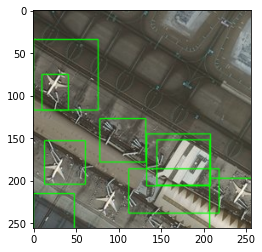

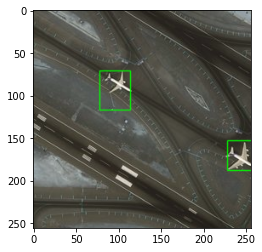

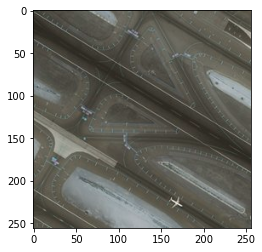

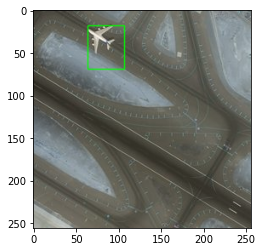

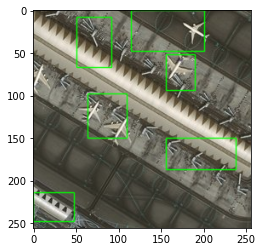

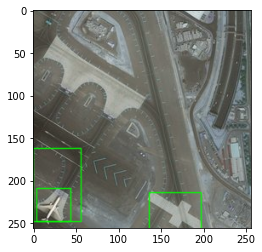

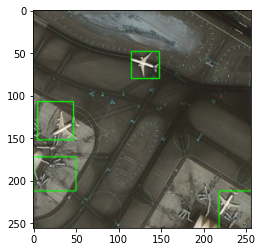

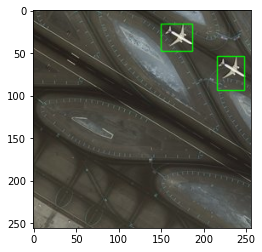

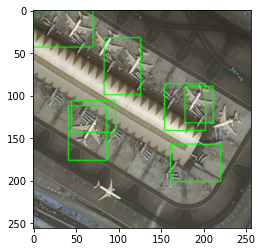

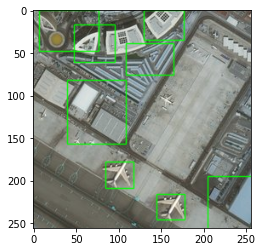

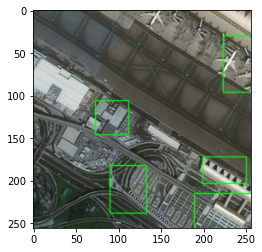

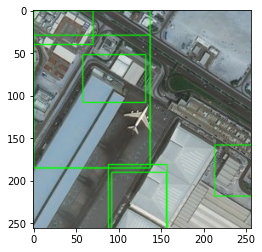

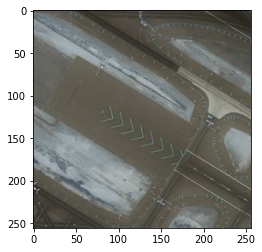

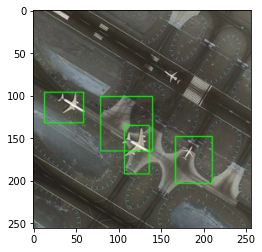

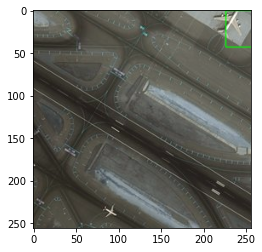

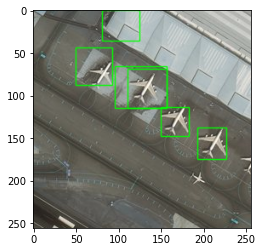

In [36]:
z = 0
for i, e in enumerate(os.listdir(image_path)):
    if e.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(image_path,e))
        ss_object.setBaseImage(img)
        ss_object.switchToSelectiveSearchFast()
        ssresults = ss_object.process()
        img_new = img.copy()
        for i,result in enumerate(ssresults):
            if i < 2000:
                x,y,w,h = result
                timage = img_new[y:y+h,x:x+w]
                resized_image = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized_image, axis=0)
                prediction = model.predict(img)
                if prediction[0][0] > 0.65:
                    cv2.rectangle(img_new, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(img_new)

## Happy Learning :)